# Games Review Sentiment

https://www.kaggle.com/account/login?returnUrl=%2Ft%2Fc1e8f08c1e69489d83fd614b9685e258

P.S. для этого соревнования 2 ноутбука - этот и еще один из google colab (для более быстрой tf-idf векторизации)




Глобально - попробовала собирать различные текстовые признаки: количество скобок, знаков препинания, заглавных букв, длину текста и тп

Векторизовывала с помощью BoW, TF-IDf с последующими понижениями размерности. Последний вариант принес наивысший результат

In [ ]:
import os
import pandas as pd
import numpy as np

import shap
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from wordcloud import WordCloud
import matplotlib.pyplot as plt

from pymystem3 import Mystem
import pymystem3
from nltk.tokenize import TweetTokenizer

from dotenv import load_dotenv

load_dotenv()

data_path = os.getenv('LOCAL_DATA')


In [2]:
train_data_path = os.path.join(data_path, "competition_2", "train.csv")
test_data_path = os.path.join(data_path, "competition_2", "test.csv")

In [3]:
train_data = pd.read_csv(train_data_path, index_col=0)
test_data = pd.read_csv(test_data_path)

print(f"Объем тренировочной выборки: {train_data.shape}, \nОбъем тестовой выборки: {test_data.shape}")

train_data

Объем тренировочной выборки: (140805, 4), 
Объем тестовой выборки: (60346, 4)


,app_id,content,author_id,is_positive
id,,,,
1,340,GG,76561198152563064,1
2,630,its fun,76561198006953365,1
3,730,POKAZUJE ZE MAM PIERDOLONE 15 PINGU A CALY CZA...,76561199082720424,0
4,730,this game suck its not the game its self its t...,76561198305268228,0
5,30,Kind of difficult to play without the source u...,76561198207922887,0
...,...,...,...,...
140801,10,я стрелял меня насиловали,76561198412836420,1
140802,240,This game is gold\n,76561199335981839,1
140803,550,"The best zombie horde shooter to this day, I w...",76561199030428167,1


In [4]:
# + еще пара файлов

steamspy_path = os.path.join(data_path, "competition_2", "output_steamspy.csv")
steamspy = pd.read_csv(steamspy_path)

train_data = pd.merge(left=train_data, right=steamspy, how='left', left_on='app_id', right_on='appid')
test_data = pd.merge(left=test_data, right=steamspy, how='left', left_on='app_id', right_on='appid')

In [5]:
train_data['is_positive'].value_counts(dropna=False)
# соотношение почти 50/50

is_positive
1    71867
0    68938
Name: count, dtype: int64

In [6]:
# убираем все id
to_drop = ['app_id', 'author_id', 'appid']

train_data = train_data.drop(to_drop, axis=1)
test_data = test_data.drop(to_drop, axis=1) 

In [7]:
# для теста

X_train, X_test, y_train, y_test = train_test_split(
    train_data.drop('is_positive', axis=1), 
    train_data['is_positive'], 
    test_size=0.2, 
    random_state=42, 
    stratify=train_data['is_positive'],
    shuffle=True
) 

In [8]:
print(X_train.shape, y_train.shape)

X_test.shape, y_test.shape

(112644, 3) (112644,)


((28161, 3), (28161,))

In [9]:
X_train.isna().sum() # то есть возможна ситуация, в которой комментария нет (?)

content     254
name       5121
owners     5121
dtype: int64

In [10]:
test_data.isna().sum() # получается, возможна

id            0
content     118
name       2746
owners     2746
dtype: int64

In [11]:
X_train[X_train['content'].isna()]

,content,name,owners
75581,NaN,Counter-Strike: Source,"10,000,000 .. 20,000,000"
64333,NaN,Half-Life 2: Lost Coast,"20,000,000 .. 50,000,000"
19280,NaN,Counter-Strike,"10,000,000 .. 20,000,000"
37788,NaN,Counter-Strike: Global Offensive,"100,000,000 .. 200,000,000"
49509,NaN,Counter-Strike,"10,000,000 .. 20,000,000"
...,...,...,...
110281,NaN,Left 4 Dead 2,"50,000,000 .. 100,000,000"
61879,NaN,Counter-Strike: Source,"10,000,000 .. 20,000,000"
52529,NaN,Half-Life: Blue Shift,"1,000,000 .. 2,000,000"
13348,NaN,Half-Life 2: Episode Two,"5,000,000 .. 10,000,000"


In [45]:
X_train = X_train.fillna('-')
X_test = X_test.fillna('-')
test_data = test_data.fillna('-')

## Анализ текста

In [13]:
text = " ".join(train_data['content'].dropna())

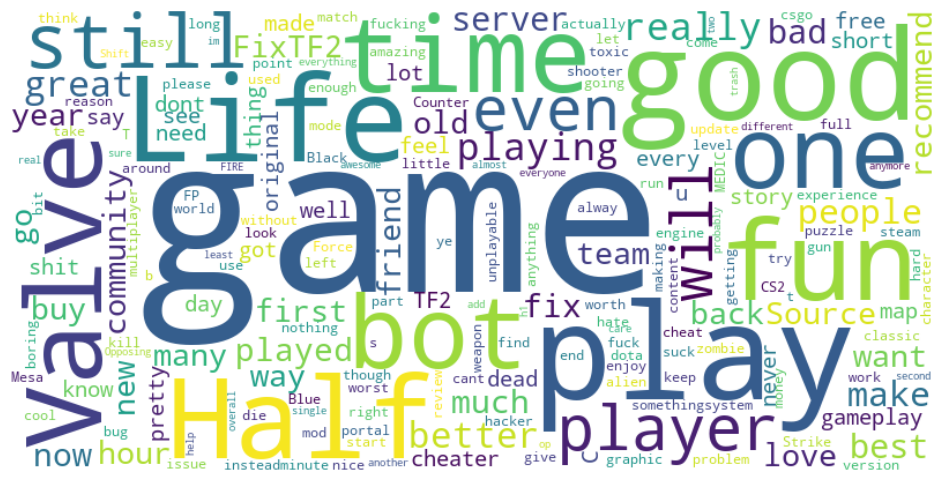

In [14]:
wc = WordCloud(width=800, height=400, background_color='white',
               stopwords=None, collocations=False)
wordcloud = wc.generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Baseline + 1 submission

В нем не будет анализа текста совсем - посмотрим, насколько полезны остальные признаки

Просто закину все в catboost, заменяя все пропуски '-' (поскольку все наши фичи - текстовые)

In [15]:
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    verbose=False,
    cat_features=['content', 'name', 'owners']
) # random_state....... :(

model.fit(X_train.fillna('-'), y_train)


In [16]:
y_pred = model.predict(X_test.fillna('-'))

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# невероятные метрики, даже без анализа текста :)

Accuracy: 0.8567167359113668

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.82      0.85     13788
           1       0.84      0.90      0.86     14373

    accuracy                           0.86     28161
   macro avg       0.86      0.86      0.86     28161
weighted avg       0.86      0.86      0.86     28161


Confusion Matrix:
 [[11259  2529]
 [ 1506 12867]]


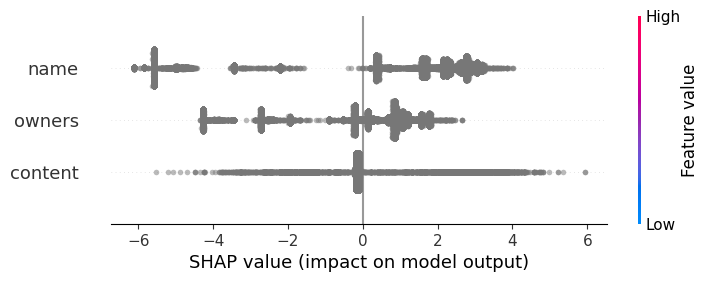

In [17]:
explainer = shap.Explainer(model)

shap_values = explainer(X_test.fillna('-'))
shap.plots.beeswarm(shap_values, max_display=50, alpha=0.5, show=False)
plt.show()

# кажется, имя уже многое говорит о характере отзывов на нее :)

In [18]:
importances = model.get_feature_importance()
sorted(importances, reverse=True)

[52.67863612723751, 36.52488547304696, 10.796478399715538]

In [19]:
predictions = model.predict(test_data.drop(['id'], axis=1).fillna('-'))

In [20]:
submission = pd.DataFrame({
    'ID': test_data['id'],
    'TARGET': predictions
})

submission.to_csv('submission.csv', index=False) 


### Результат сабмита: 0.86553

## 1.1 

In [28]:
test_data[['content', 'name', 'owners']]

,content,name,owners
0,NaN,Counter-Strike,"10,000,000 .. 20,000,000"
1,Unless you're into puzzle games I wouldn't rec...,Portal,"10,000,000 .. 20,000,000"
2,It's a older version of Helldivers essentially...,Alien Swarm,"2,000,000 .. 5,000,000"
3,yee,Alien Swarm,"2,000,000 .. 5,000,000"
4,We'll see.. about That,Half-Life 2: Episode One,"5,000,000 .. 10,000,000"
...,...,...,...
60341,no time to play....,Alien Swarm,"2,000,000 .. 5,000,000"
60342,Deathmatch Classic,Deathmatch Classic,"5,000,000 .. 10,000,000"
60343,Na,Counter-Strike,"10,000,000 .. 20,000,000"
60344,are you guys going trick or treating,NaN,NaN


In [51]:
cb_params = dict(
    iterations=1000,               # большое max-число
    learning_rate=0.1,
    depth=6,
    random_state=42,
    verbose=True,
    cat_features=['content', 'name', 'owners'],
    early_stopping_rounds=50       # остановимся, если нет улучшения 50 итераций
)

In [29]:
from sklearn.model_selection import StratifiedKFold

cb_params = dict(
    iterations=10000,               # большое max-число
    learning_rate=0.1,
    depth=6,
    random_state=42,
    verbose=True,
    cat_features=['content', 'name', 'owners'],
    early_stopping_rounds=50       # остановимся, если нет улучшения 50 итераций
)

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Массивы для OOF и тестовых предсказаний
oof_pred = np.zeros(len(X_train))
test_pred = np.zeros(len(X_test))

test_test_pred = np.zeros(len(test_data))

for fold, (tr_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    print(fold)
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]

    model = CatBoostClassifier(**cb_params)
    model.fit(
        X_tr.fillna('-'),
        y_tr,
        eval_set=(X_val.fillna('-'), y_val),
        use_best_model=True
    )

    # OOF-предсказания на валидацию
    oof_pred[val_idx] = model.predict_proba(X_val.fillna('-'))[:, 1]
    # Суммируем тестовые предсказания для усреднения
    test_pred += model.predict_proba(X_test.fillna('-'))[:, 1] / n_splits
    test_test_pred += model.predict_proba(test_data[['content', 'name', 'owners']].fillna('-'))[:, 1] / n_splits


0
0:	learn: 0.5754122	test: 0.5747311	best: 0.5747311 (0)	total: 124ms	remaining: 20m 43s
1:	learn: 0.5300784	test: 0.5296945	best: 0.5296945 (1)	total: 258ms	remaining: 21m 31s
2:	learn: 0.4911199	test: 0.4901787	best: 0.4901787 (2)	total: 396ms	remaining: 21m 59s
3:	learn: 0.4641311	test: 0.4635023	best: 0.4635023 (3)	total: 512ms	remaining: 21m 19s
4:	learn: 0.4278950	test: 0.4272957	best: 0.4272957 (4)	total: 660ms	remaining: 21m 58s
5:	learn: 0.4143115	test: 0.4137813	best: 0.4137813 (5)	total: 773ms	remaining: 21m 27s
6:	learn: 0.4040944	test: 0.4036456	best: 0.4036456 (6)	total: 863ms	remaining: 20m 32s
7:	learn: 0.3952510	test: 0.3948234	best: 0.3948234 (7)	total: 982ms	remaining: 20m 26s
8:	learn: 0.3876808	test: 0.3871738	best: 0.3871738 (8)	total: 1.09s	remaining: 20m 15s
9:	learn: 0.3825602	test: 0.3820301	best: 0.3820301 (9)	total: 1.21s	remaining: 20m 10s
10:	learn: 0.3696750	test: 0.3677781	best: 0.3677781 (10)	total: 1.33s	remaining: 20m 6s
11:	learn: 0.3605612	test: 0.

In [ ]:
y_pred = (test_pred > 0.5) * 1 # в классы

In [36]:

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# невероятные метрики, даже без анализа текста :)

Accuracy: 0.8568942864244877

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.82      0.85     13788
           1       0.84      0.89      0.86     14373

    accuracy                           0.86     28161
   macro avg       0.86      0.86      0.86     28161
weighted avg       0.86      0.86      0.86     28161


Confusion Matrix:
 [[11269  2519]
 [ 1511 12862]]


In [37]:
# что мне надо? сохранить предсказания для трейна, теста, и сабмита

X_train['model_score'] = oof_pred
X_test['model_score'] = test_pred
test_data['model_score'] = test_test_pred

In [44]:
X_train.to_csv('X_train.csv', sep=';')
X_test.to_csv('X_test.csv', sep=';')
test_data.to_csv('test_data.csv', sep=';')

In [46]:
test_data

,id,content,name,owners,model_score
0,1,-,Counter-Strike,"10,000,000 .. 20,000,000",0.933011
1,2,Unless you're into puzzle games I wouldn't rec...,Portal,"10,000,000 .. 20,000,000",0.525188
2,3,It's a older version of Helldivers essentially...,Alien Swarm,"2,000,000 .. 5,000,000",0.950827
3,4,yee,Alien Swarm,"2,000,000 .. 5,000,000",0.993474
4,5,We'll see.. about That,Half-Life 2: Episode One,"5,000,000 .. 10,000,000",0.749506
...,...,...,...,...,...
60341,60342,no time to play....,Alien Swarm,"2,000,000 .. 5,000,000",0.950827
60342,60343,Deathmatch Classic,Deathmatch Classic,"5,000,000 .. 10,000,000",0.827320
60343,60344,Na,Counter-Strike,"10,000,000 .. 20,000,000",0.819218
60344,60345,are you guys going trick or treating,-,-,0.639866


In [43]:
(test_data['model_score'] > 0.5).sum()
# хорошее распределение таргета

32940

## 2. Признаки из текста

In [47]:
X_train['content_length'] = X_train['content'].str.len().fillna(0)
X_train['open_paren_count']  = X_train['content'].str.count(r'\(').fillna(0)
X_train['close_paren_count'] = X_train['content'].str.count(r'\)').fillna(0)

X_train['exclamation_count'] = X_train['content'].str.count(r'!').fillna(0)
X_train['question_count']    = X_train['content'].str.count(r'\?').fillna(0)

X_train['digit_count'] = X_train['content'].str.count(r'\d').fillna(0)

X_train['uppercase_word_count'] = X_train['content'].astype(str).apply(
        lambda text: sum(1 for w in text.split() if w.isupper())
).fillna(0)

X_train['punctuation_count'] = X_train['content'].str.count(r'[^\w\s]').fillna(0)

In [48]:
X_test['content_length'] = X_test['content'].str.len().fillna(0)
X_test['open_paren_count']  = X_test['content'].str.count(r'\(').fillna(0)
X_test['close_paren_count'] = X_test['content'].str.count(r'\)').fillna(0)

X_test['exclamation_count'] = X_test['content'].str.count(r'!').fillna(0)
X_test['question_count']    = X_test['content'].str.count(r'\?').fillna(0)

X_test['digit_count'] = X_test['content'].str.count(r'\d').fillna(0)

X_test['uppercase_word_count'] = X_test['content'].astype(str).apply(
        lambda text: sum(1 for w in text.split() if w.isupper())
).fillna(0)

X_test['punctuation_count'] = X_test['content'].str.count(r'[^\w\s]').fillna(0)


In [60]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train.drop('model_score', axis=1).fillna('-'),  # заполняем пропуски
    y_train,
    test_size=0.2,         # 20% на валидацию
    stratify=y_train,      # сохраняем баланс классов
    random_state=42
)

In [61]:
model_ = CatBoostClassifier(
    iterations=10000,
    learning_rate=0.1,
    depth=6,
    random_state=42,
    verbose=False,
    cat_features=['content', 'name', 'owners'],
    early_stopping_rounds=50
)

# 3. Обучаем с валидацией
model_.fit(
    X_tr, 
    y_tr,
    eval_set=(X_val, y_val),
    use_best_model=True,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [56]:
model = CatBoostClassifier(
    iterations=10000,
    learning_rate=0.1,
    depth=6,
    random_state=42,
    verbose=False,
    cat_features=['content', 'name', 'owners'],
    early_stopping_rounds=50
)

# 3. Обучаем с валидацией
model.fit(
    X_tr, 
    y_tr,
    eval_set=(X_val, y_val),
    use_best_model=True,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [63]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# на 1 сотую лучше

Accuracy: 0.8659493625936578

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.81      0.86     13788
           1       0.83      0.92      0.88     14373

    accuracy                           0.87     28161
   macro avg       0.87      0.86      0.87     28161
weighted avg       0.87      0.87      0.87     28161


Confusion Matrix:
 [[11172  2616]
 [ 1159 13214]]


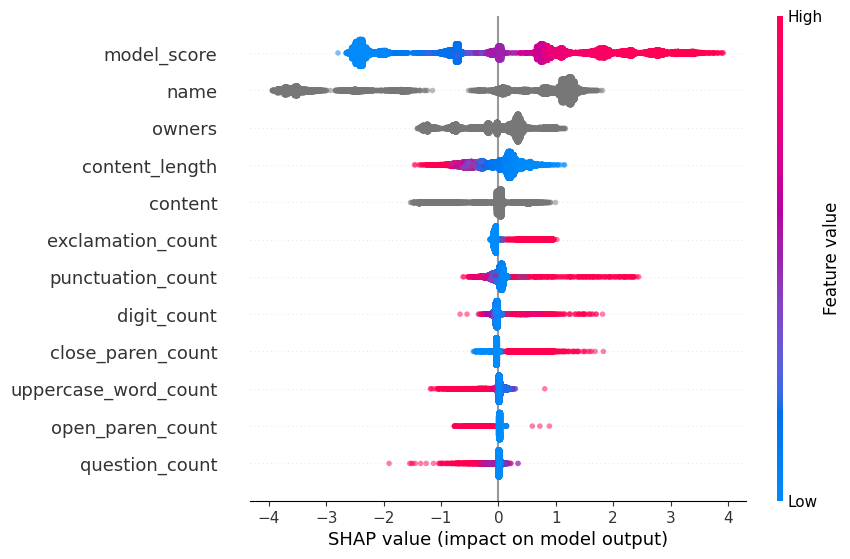

In [64]:
explainer = shap.Explainer(model)

shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values, max_display=50, alpha=0.5, show=False)
plt.show()

# кажется, имя уже многое говорит о характере отзывов на нее :)

In [65]:
importances = model.get_feature_importance()
sorted(importances, reverse=True)

[42.86761321637416,
 21.382990262175927,
 12.314019344434401,
 7.856211379425189,
 3.0513122116850626,
 2.8415343192023768,
 2.7079764315104287,
 1.8015770302258827,
 1.711628788071537,
 1.7056640839990584,
 0.8813047469578706,
 0.8781681859380673]

In [66]:
test_data

,id,content,name,owners,model_score
0,1,-,Counter-Strike,"10,000,000 .. 20,000,000",0.933011
1,2,Unless you're into puzzle games I wouldn't rec...,Portal,"10,000,000 .. 20,000,000",0.525188
2,3,It's a older version of Helldivers essentially...,Alien Swarm,"2,000,000 .. 5,000,000",0.950827
3,4,yee,Alien Swarm,"2,000,000 .. 5,000,000",0.993474
4,5,We'll see.. about That,Half-Life 2: Episode One,"5,000,000 .. 10,000,000",0.749506
...,...,...,...,...,...
60341,60342,no time to play....,Alien Swarm,"2,000,000 .. 5,000,000",0.950827
60342,60343,Deathmatch Classic,Deathmatch Classic,"5,000,000 .. 10,000,000",0.827320
60343,60344,Na,Counter-Strike,"10,000,000 .. 20,000,000",0.819218
60344,60345,are you guys going trick or treating,-,-,0.639866


In [67]:
test_data['content_length'] = test_data['content'].str.len().fillna(0)
test_data['open_paren_count']  = test_data['content'].str.count(r'\(').fillna(0)
test_data['close_paren_count'] = test_data['content'].str.count(r'\)').fillna(0)

test_data['exclamation_count'] = test_data['content'].str.count(r'!').fillna(0)
test_data['question_count']    = test_data['content'].str.count(r'\?').fillna(0)

test_data['digit_count'] = test_data['content'].str.count(r'\d').fillna(0)

test_data['uppercase_word_count'] = test_data['content'].astype(str).apply(
        lambda text: sum(1 for w in text.split() if w.isupper())
).fillna(0)

test_data['punctuation_count'] = test_data['content'].str.count(r'[^\w\s]').fillna(0)


In [68]:
test_data

,id,content,name,owners,model_score,content_length,open_paren_count,close_paren_count,exclamation_count,question_count,digit_count,uppercase_word_count,punctuation_count
0,1,-,Counter-Strike,"10,000,000 .. 20,000,000",0.933011,1,0,0,0,0,0,0,1
1,2,Unless you're into puzzle games I wouldn't rec...,Portal,"10,000,000 .. 20,000,000",0.525188,604,0,0,0,0,2,4,19
2,3,It's a older version of Helldivers essentially...,Alien Swarm,"2,000,000 .. 5,000,000",0.950827,134,0,0,0,0,1,0,4
3,4,yee,Alien Swarm,"2,000,000 .. 5,000,000",0.993474,3,0,0,0,0,0,0,0
4,5,We'll see.. about That,Half-Life 2: Episode One,"5,000,000 .. 10,000,000",0.749506,22,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60341,60342,no time to play....,Alien Swarm,"2,000,000 .. 5,000,000",0.950827,19,0,0,0,0,0,0,4
60342,60343,Deathmatch Classic,Deathmatch Classic,"5,000,000 .. 10,000,000",0.827320,18,0,0,0,0,0,0,0
60343,60344,Na,Counter-Strike,"10,000,000 .. 20,000,000",0.819218,2,0,0,0,0,0,0,0
60344,60345,are you guys going trick or treating,-,-,0.639866,36,0,0,0,0,0,0,0


In [69]:
predictions = model.predict(test_data.drop(['id'], axis=1))

In [71]:
predictions.sum()

33866

In [72]:
submission = pd.DataFrame({
    'id': test_data['id'],
    'sentiment': predictions
})

submission.to_csv('submission.csv', index=False) 


## 2. Работа с текстом

In [74]:
X_train

,content,name,owners,model_score,content_length,open_paren_count,close_paren_count,exclamation_count,question_count,digit_count,uppercase_word_count,punctuation_count
27887,i miss csgo,Counter-Strike: Global Offensive,"100,000,000 .. 200,000,000",0.252871,11,0,0,0,0,0,0,0
89458,2/10 no fish ai,Counter-Strike: Source,"10,000,000 .. 20,000,000",0.791153,15,0,0,0,0,3,0,1
47101,"This game is so silly because I shoot the ""inf...",Left 4 Dead 2,"50,000,000 .. 100,000,000",0.489242,180,0,0,3,0,0,3,8
18725,You've managed to make me not care about the c...,Half-Life 2: Episode Two,"5,000,000 .. 10,000,000",0.444210,127,0,0,0,0,1,1,4
21403,I don't recommend this because Left 4 Dead 2 i...,Left 4 Dead,"5,000,000 .. 10,000,000",0.000905,139,0,0,0,0,4,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...
34460,Childhood game DABEEESSSTTTTTT!!!!,Left 4 Dead 2,"50,000,000 .. 100,000,000",0.500135,34,0,0,4,0,0,1,4
135653,ive loved the game since i started out on a cr...,Counter-Strike,"10,000,000 .. 20,000,000",0.800582,114,0,0,0,0,4,0,2
17015,Any Half Life fan of course needs to play this!,Half-Life 2: Episode One,"5,000,000 .. 10,000,000",0.736046,47,0,0,1,0,0,0,1
74027,i hate that disgusting fat motherfucker that i...,Left 4 Dead 2,"50,000,000 .. 100,000,000",0.496303,114,0,0,0,0,0,0,2


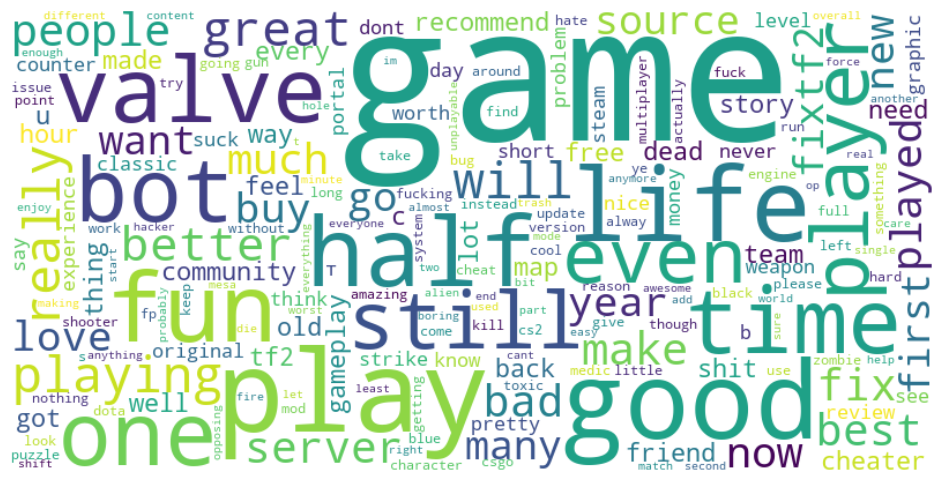

In [76]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = " ".join(X_train['content'].str.lower())

wc = WordCloud(width=800, height=400, background_color='white',
               stopwords=None, collocations=False)
wordcloud = wc.generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [77]:
from collections import Counter
import re

texts = X_train['content'].astype(str).str.lower()

tokens = texts.apply(lambda x: re.findall(r'\b\w+\b', x))

all_tokens = [token for sublist in tokens for token in sublist]

counter = Counter(all_tokens)

# Выводим число уникальных слов
print(f"Уникальных слов: {len(counter)}")

Уникальных слов: 66904


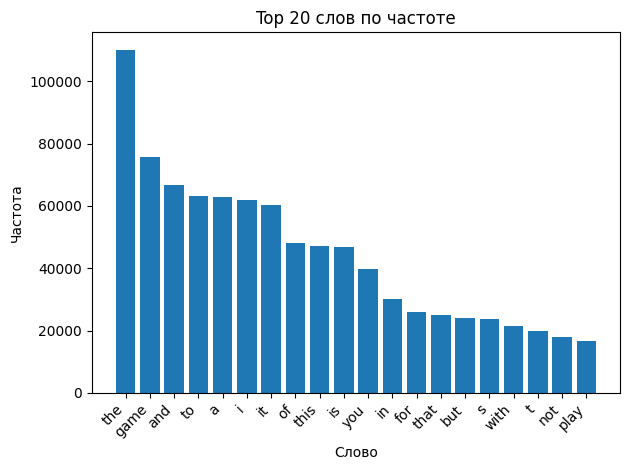

In [78]:
top_n = 20
common = counter.most_common(top_n)
words, freqs = zip(*common)

# Строим столбчатый график
plt.figure()
plt.bar(range(top_n), freqs)
plt.xticks(range(top_n), words, rotation=45, ha='right')
plt.xlabel('Слово')
plt.ylabel('Частота')
plt.title(f'Top {top_n} слов по частоте')
plt.tight_layout()
plt.show()

In [80]:
word_5000, freq_5000 = counter.most_common()[4999]
f"5000-е слово по частоте: '{word_5000}', встречается {freq_5000} раз"

"5000-е слово по частоте: 'rotation', встречается 27 раз"

In [93]:
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sibfl\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sibfl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [86]:
stop_words = set(stopwords.words('english') + stopwords.words('russian'))

In [105]:
# визуализация облака слов для выделенного фактора/кластера/темы
def words_to_cloud(documents: list[str], stopwords: list[str], tokenizer) -> list[str]:

  """
  Предобработка текста перед тематическим моделированием

  Args:
    documents (list[str]): список документов
    stopwords (list[str]): список стоп-слов
    tokenizer: способ разделения предложений на токены
    threshold_common_words (float): пороговое значение для удаления наименее встречающихся слов

  Returns:
    list[str]: список предобработанных документов
  """

  # токенизация + удаление стоп-слов + набор всех токенов
  cleaned_documents = []
  tokens = []
  for document in documents:
    cleaned_doc = []
    tokenized = tokenizer.tokenize(document)
    for token in tokenized:
      token = token.lower()
      if (re.match(r'^[a-zа-я]+$', token)) and (token not in stopwords) and (len(token) > 1):
        cleaned_doc.append(token)
        tokens.append(token)
    cleaned_documents.append(cleaned_doc)

  # лемматизация
  mystem = Mystem()
  lemmatize_docs = []
  for i in range(len(cleaned_documents)):
    mess = ' '.join(cleaned_documents[i])
    lemmatized_words = mystem.lemmatize(mess)
    lemmatized_text = ''.join(lemmatized_words).replace('\n', ' ')
    lemmatize_docs.append(lemmatized_text)

  # удаление стоп-слов (если необходимо)
  docs_with_most_common_words = []
  for document in lemmatize_docs:
      message = [word for word in document.split() if word not in stop_words]
      docs_with_most_common_words.append(' '.join(message))

  return docs_with_most_common_words

In [ ]:
X_train['clear_content'] = words_to_cloud(X_train['content'].values, stopwords=stop_words, tokenizer=TweetTokenizer())
X_test['clear_content'] = words_to_cloud(X_test['content'].values, stopwords=stop_words, tokenizer=TweetTokenizer())
test_data['clear_content'] = words_to_cloud(test_data['content'].values, stopwords=stop_words, tokenizer=TweetTokenizer())

In [112]:
X_train = pd.read_csv('X_train.csv', sep=';', index_col=0)
X_test = pd.read_csv('X_test.csv', sep=';', index_col=0)
test_data = pd.read_csv('test_data.csv', sep=';', index_col=0)

X_train

,content,name,owners,model_score,clean_content
27887,i miss csgo,Counter-Strike: Global Offensive,"100,000,000 .. 200,000,000",0.252871,miss csgo
89458,2/10 no fish ai,Counter-Strike: Source,"10,000,000 .. 20,000,000",0.791153,fish ai
47101,"This game is so silly because I shoot the ""inf...",Left 4 Dead 2,"50,000,000 .. 100,000,000",0.489242,game silly shoot infected people go aaieeehage...
18725,You've managed to make me not care about the c...,Half-Life 2: Episode Two,"5,000,000 .. 10,000,000",0.444210,managed make care continuation ending ip enjoy...
21403,I don't recommend this because Left 4 Dead 2 i...,Left 4 Dead,"5,000,000 .. 10,000,000",0.000905,recommend left dead superior every way making ...
...,...,...,...,...,...
34460,Childhood game DABEEESSSTTTTTT!!!!,Left 4 Dead 2,"50,000,000 .. 100,000,000",0.500135,childhood game dabeeessstttttt
135653,ive loved the game since i started out on a cr...,Counter-Strike,"10,000,000 .. 20,000,000",0.800582,ive loved game since started cracked version c...
17015,Any Half Life fan of course needs to play this!,Half-Life 2: Episode One,"5,000,000 .. 10,000,000",0.736046,half life fan course needs play
74027,i hate that disgusting fat motherfucker that i...,Left 4 Dead 2,"50,000,000 .. 100,000,000",0.496303,hate disgusting fat motherfucker always blowin...


In [ ]:
X_train.fillna('-')

In [114]:
X_train.isna().sum()

content           254
name             5121
owners           5121
model_score         0
clean_content    5808
dtype: int64

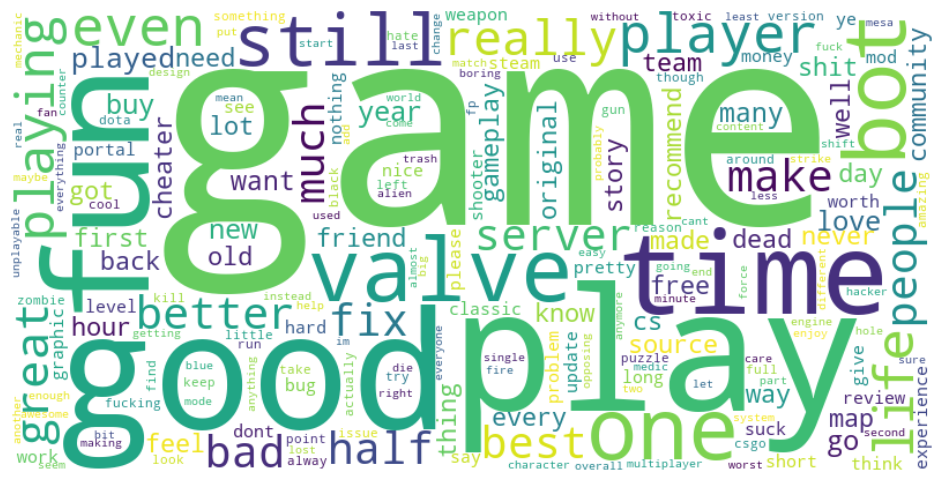

In [117]:
wc = WordCloud(width=800, height=400, background_color='white',
               stopwords=None, collocations=False)

text = ' '.join(X_train['clean_content'].fillna('-').values)
wordcloud = wc.generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [128]:
all_tokens = (' '.join(X_train['clean_content'].fillna('-').values)).split()
counter = Counter(all_tokens)

# Выводим число уникальных слов
print(f"Уникальных слов: {len(counter)}")

Уникальных слов: 54684


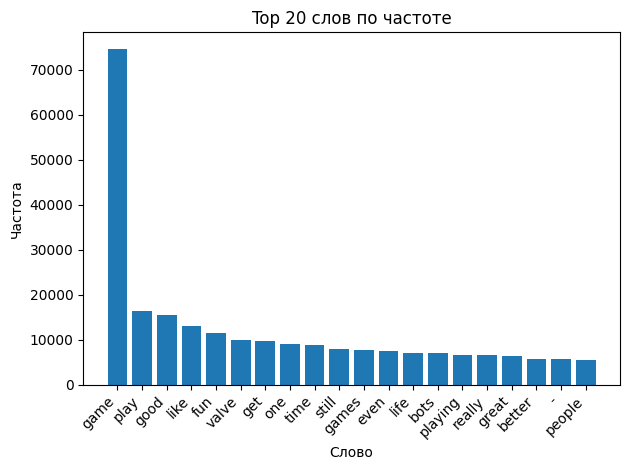

In [129]:
top_n = 20
common = counter.most_common(top_n)
words, freqs = zip(*common)

# Строим столбчатый график
plt.figure()
plt.bar(range(top_n), freqs)
plt.xticks(range(top_n), words, rotation=45, ha='right')
plt.xlabel('Слово')
plt.ylabel('Частота')
plt.title(f'Top {top_n} слов по частоте')
plt.tight_layout()
plt.show()

In [155]:
y_train.to_csv('y_train.csv', sep=';')
y_test.to_csv('y_test.csv', sep=';')

In [130]:
word_5000, freq_5000 = counter.most_common()[4999]
f"5000-е слово по частоте: '{word_5000}', встречается {freq_5000} раз"

"5000-е слово по частоте: 'fortunately', встречается 23 раз"

In [131]:
word_10000, freq_10000 = counter.most_common()[9999]
f"10000-е слово по частоте: '{word_10000}', встречается {freq_10000} раз"

"10000-е слово по частоте: 'obscurity', встречается 7 раз"

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

texts = X_train['clean_content'].astype(str).tolist()
vectorizer = TfidfVectorizer(
    max_features=5000,      # оставляем только 5000 наиболее «значимых» слов
    lowercase=False,        # тексты уже приведены к нижнему регистру, либо можно True
)

In [134]:
X_tfidf = vectorizer.fit_transform(texts)

In [136]:
tfidf_df = pd.DataFrame(
    X_tfidf.toarray(),
    columns=vectorizer.get_feature_names_out(),
    index=X_train.index
)

In [137]:
tfidf_df

,aaa,abandon,abandoned,abandoning,abandonware,abilities,ability,able,absence,absolute,...,убивать,хороший,хотеть,хуета,хуйня,час,человек,читер,это,этот
27887,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89458,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18725,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21403,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34460,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
135653,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [154]:
X_train = pd.concat([X_train, tfidf_df.drop(['name', 'content', 'owners'], axis=1)], axis=1)


MemoryError: Unable to allocate 4.20 GiB for an array with shape (5001, 112644) and data type float64

In [142]:
X_train

,content,name,owners,model_score,clean_content,aaa,abandon,abandoned,abandoning,abandonware,...,убивать,хороший,хотеть,хуета,хуйня,час,человек,читер,это,этот
27887,i miss csgo,Counter-Strike: Global Offensive,"100,000,000 .. 200,000,000",0.252871,miss csgo,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89458,2/10 no fish ai,Counter-Strike: Source,"10,000,000 .. 20,000,000",0.791153,fish ai,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47101,"This game is so silly because I shoot the ""inf...",Left 4 Dead 2,"50,000,000 .. 100,000,000",0.489242,game silly shoot infected people go aaieeehage...,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18725,You've managed to make me not care about the c...,Half-Life 2: Episode Two,"5,000,000 .. 10,000,000",0.444210,managed make care continuation ending ip enjoy...,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21403,I don't recommend this because Left 4 Dead 2 i...,Left 4 Dead,"5,000,000 .. 10,000,000",0.000905,recommend left dead superior every way making ...,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34460,Childhood game DABEEESSSTTTTTT!!!!,Left 4 Dead 2,"50,000,000 .. 100,000,000",0.500135,childhood game dabeeessstttttt,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
135653,ive loved the game since i started out on a cr...,Counter-Strike,"10,000,000 .. 20,000,000",0.800582,ive loved game since started cracked version c...,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17015,Any Half Life fan of course needs to play this!,Half-Life 2: Episode One,"5,000,000 .. 10,000,000",0.736046,half life fan course needs play,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74027,i hate that disgusting fat motherfucker that i...,Left 4 Dead 2,"50,000,000 .. 100,000,000",0.496303,hate disgusting fat motherfucker always blowin...,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [143]:

test_texts  = X_test ['clean_content'].astype(str).tolist()

X_test_tfidf = vectorizer.transform(test_texts)

test_tfidf_df = pd.DataFrame(
    X_test_tfidf.toarray(),
    columns=vectorizer.get_feature_names_out(),
    index=X_test.index
)

# 6. Конкатенируем к X_test
X_test = pd.concat([X_test, test_tfidf_df], axis=1)

In [148]:
model_ = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    random_state=42,
    verbose=False,
    cat_features=['name', 'owners'],
    early_stopping_rounds=50
)

# 3. Обучаем с валидацией
model_.fit(
    X_train.drop(['content', 'clean_content'], axis=1), 
    y_train,
    use_best_model=True,
    plot=True
)

CatBoostError: catboost/libs/data/features_layout.cpp:124: All feature names should be different, but 'name' used more than once.

In [152]:
X_train.drop(['name'], axis=1)

,content,owners,model_score,clean_content,aaa,abandon,abandoned,abandoning,abandonware,abilities,...,убивать,хороший,хотеть,хуета,хуйня,час,человек,читер,это,этот
27887,i miss csgo,"100,000,000 .. 200,000,000",0.252871,miss csgo,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89458,2/10 no fish ai,"10,000,000 .. 20,000,000",0.791153,fish ai,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47101,"This game is so silly because I shoot the ""inf...","50,000,000 .. 100,000,000",0.489242,game silly shoot infected people go aaieeehage...,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18725,You've managed to make me not care about the c...,"5,000,000 .. 10,000,000",0.444210,managed make care continuation ending ip enjoy...,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21403,I don't recommend this because Left 4 Dead 2 i...,"5,000,000 .. 10,000,000",0.000905,recommend left dead superior every way making ...,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34460,Childhood game DABEEESSSTTTTTT!!!!,"50,000,000 .. 100,000,000",0.500135,childhood game dabeeessstttttt,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
135653,ive loved the game since i started out on a cr...,"10,000,000 .. 20,000,000",0.800582,ive loved game since started cracked version c...,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17015,Any Half Life fan of course needs to play this!,"5,000,000 .. 10,000,000",0.736046,half life fan course needs play,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74027,i hate that disgusting fat motherfucker that i...,"50,000,000 .. 100,000,000",0.496303,hate disgusting fat motherfucker always blowin...,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# оставшаяся чатсь в google colab